# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
#from scipy.misc import imresize # this is deprecated
import datetime
import os

import imageio # using as an alternative of imread as it is deprecated
from PIL import Image # using as an alternative of imread as it is deprecated

import matplotlib.pyplot as plt
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

from imageio import imread
from skimage.transform import resize

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
#batch_size = 32 #experiment with the batch size

In [4]:
len(train_doc)

663

In [5]:
len(val_doc)

100

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,18,84,84,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx):
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32) #cropping the (120X160) image to make (120X120)
                    else:
                        #print("")
                        image = resize(image,(84,84)).astype(np.float32)
                    # Normalizing RGB image with mean subtraction 
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        
        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size!=0):
            batch_data = np.zeros((len(t)%batch_size,18,84,84,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*(len(t)%batch_size))].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*(len(t)%batch_size))].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)
                    # Normalizing RGB image with mean subtraction
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                                        
                batch_labels[folder, int(t[folder + (num_batches*(len(t)%batch_size))].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, TimeDistributed
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here

Input_shape = (18, 84, 84, 3)

model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'), input_shape=(18,84,84,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2))))

model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2))))

model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [14]:
optimiser = optimizers.SGD(learning_rate = 0.01)
#optimiser = optimizers.SGD(lr=0.001, decay=1e-6)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 18, 84, 84, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 84, 84, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 42, 42, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 18, 42, 42, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 18, 42, 42, 32)  

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [15]:
batch_size = 32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [16]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [18]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/30


2022-11-20 08:14:12.785346: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.5690 - categorical_accuracy: 0.3228Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2022-11-2008_12_05.094091/model-00001-1.56899-0.32278-1.92756-0.21000.h5
21/21 [==============================] - 101s 5s/step - loss: 1.5690 - categorical_accuracy: 0.3228 - val_loss: 1.9276 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.2132 - categorical_accuracy: 0.5098
Epoch 00002: saving model to model_init_2022-11-2008_12_05.094091/model-00002-1.21323-0.50980-2.20656-0.19000.h5
21/21 [==============================] - 100s 5s/step - loss: 1.2132 - categorical_accuracy: 0.5098 - val_loss: 2.2066 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.9656 - categorical_accuracy: 0.6410
Epoch 00003: saving model to model_init_2022-11-2008_12_05.094091/mo

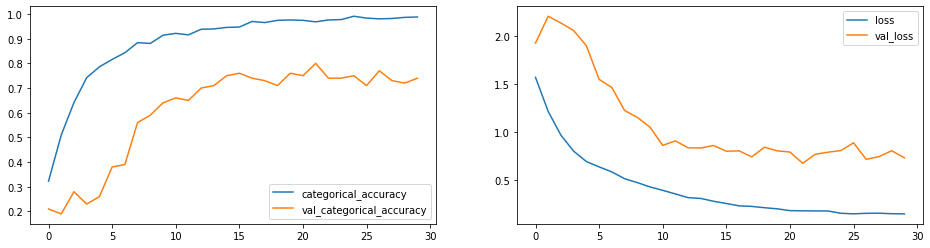

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(model.history.history['categorical_accuracy'])   
axes[0].plot(model.history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(model.history.history['loss'])   
axes[1].plot(model.history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

## Predictions

In [6]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

In [7]:
t = np.random.permutation(train_doc)

In [8]:
# All types of action : Left swipe, Right swipe, Stop, Thumbs down, Thumbs up
print(t[1].split(';'))
print(t[6].split(';'))
print(t[5].split(';'))
print(t[0].split(';'))
print(t[4].split(';'))

['WIN_20180926_17_35_17_Pro_Stop_new', 'Stop_new', '2\n']
['WIN_20180925_17_22_11_Pro_Thumbs_Up_new', 'Thumbs_Up_new', '4\n']
['WIN_20180926_17_33_51_Pro_Thumbs_Up_new', 'Thumbs_Up_new', '4\n']
['WIN_20180926_17_24_58_Pro_Right_Swipe_new', 'Right_Swipe_new', '1\n']
['WIN_20180926_16_58_12_Pro_Left_Swipe_new', 'Left_Swipe_new', '0\n']


In [23]:
images = os.listdir(train_path+'/'+t[2].strip().split(';')[0])

In [24]:
images[0]

'WIN_20180925_17_58_10_Pro_00002.png'

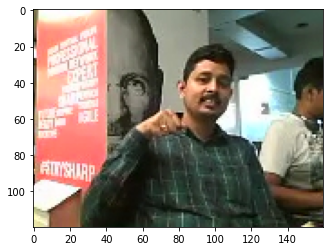

In [32]:
image_1=imageio.imread(train_path+'/'+ t[2].strip().split(';')[0]+'/'+ images[0]).astype(np.float32)
plt.imshow(image_1.astype('uint8'))

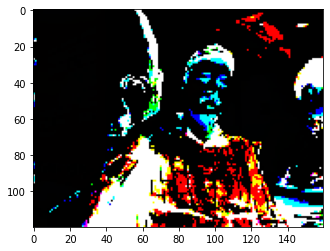

In [42]:
image_1[:,:,0] = (image_1[:,:,0] - image_1[:,:,0].mean())/image_1[:,:,0].std()
image_1[:,:,1] = (image_1[:,:,1] - image_1[:,:,1].mean())/image_1[:,:,1].std()
image_1[:,:,2] = (image_1[:,:,2] - image_1[:,:,2].mean())/image_1[:,:,2].std()
plt.imshow(image_1.astype('uint8'))

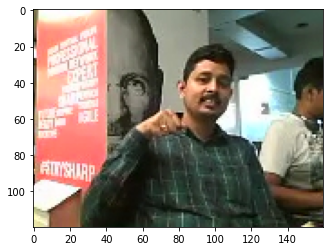

In [28]:
image_1=imageio.imread(train_path+'/'+ t[2].strip().split(';')[0]+'/'+ images[0]).astype(np.float32)
plt.imshow(image_1.astype('uint8'))

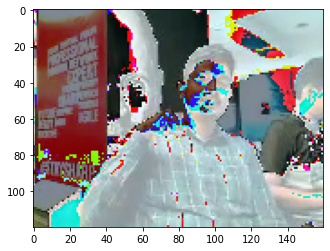

In [29]:
image_1[:,:,0] = (image_1[:,:,0] - image_1[:,:,0].mean())
image_1[:,:,1] = (image_1[:,:,1] - image_1[:,:,1].mean())
image_1[:,:,2] = (image_1[:,:,2] - image_1[:,:,2].mean())
plt.imshow(image_1.astype('uint8'))

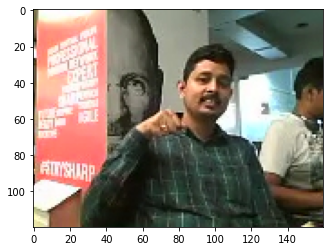

In [30]:
image_1=imageio.imread(train_path+'/'+ t[2].strip().split(';')[0]+'/'+ images[0]).astype(np.float32)
plt.imshow(image_1.astype('uint8'))

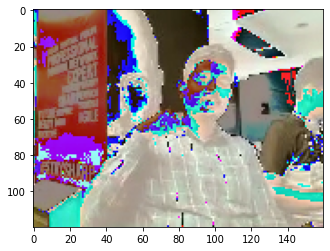

In [31]:
image_1[:,:,0] = image_1[:,:,0] - 104
image_1[:,:,1] = image_1[:,:,1] - 117
image_1[:,:,2] = image_1[:,:,2] - 123
plt.imshow(image_1.astype('uint8'))

In [86]:
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
actions = [1, 6, 5, 0, 4]

In [87]:
actions[0]

1

In [90]:

def Preprocess_data(img_idx, action):
    batch_data = np.zeros((5,18,84,84,3))
    batch_labels = np.zeros((5,5))
    for i in range(5): 
        images = os.listdir(train_path+'/'+t[actions[i]].strip().split(';')[0])
        for idx,item in enumerate(img_idx):
            image = imageio.imread(train_path+'/'+ t[actions[i]].strip().split(';')[0]+'/'+ images[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            if image.shape[1] == 160:
                image = resize(image[:,20:140,:],(84,84)).astype(np.float32) #cropping the (120X160) image to make (120X120)
            else:
                #print("")
                image = resize(image,(84,84)).astype(np.float32)
            # Normalizing RGB image with mean subtraction 
            batch_data[i,idx,:,:,0] = image[:,:,0] - 104
            batch_data[i,idx,:,:,1] = image[:,:,1] - 117
            batch_data[i,idx,:,:,2] = image[:,:,2] - 123

        batch_labels[i, int(t[action[i]].split(';')[2])] = 1
    return batch_data, batch_labels

In [91]:
batch_1 = Preprocess_data(img_idx, actions)

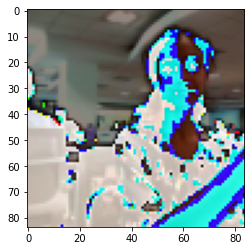

In [110]:
plt.imshow(batch_1[0][0][12].astype('uint8'))

In [111]:
model.load_weights('/home/dl_content/Upgrad DL/Gesture Recognition Assignment/model_init_2022-11-1913_52_26.393692/model-00030-0.15590-0.93967-0.34338-0.87000.h5')

In [114]:
output = model.predict(batch_1[0])

In [116]:
np.argmax(output, axis=0)

array([0, 1, 2, 3, 4])